<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/video_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'><center>**Video Classification**</center></font>

Here I am using a sample of videos from the VoxCeleb dataset for gender classification. In this notebook, I am using a 3D CNN model for video classification. 

VoxCeleb dataset - https://www.robots.ox.ac.uk/~vgg/data/voxceleb/

In [ ]:
#import libraries
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math
import random

# **Download and unzip the data**

In [ ]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"


--2021-10-05 10:21:28--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  28.5MB/s    in 5m 1s   

2021-10-05 10:26:30 (28.2 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

# **Organizing the data**

In the cells below I have collected all the video paths and put them to a list. Since the number of videos are too big and for memory issues, I will be feeding the paths to a datagenerator to provide batches of videos to the CNN model.

In [ ]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

In [ ]:
#number of videos available
print('Number of videos available: ', len(vid_paths))

#shuffle video paths. I have used a random seed of 4 to shuffle.
random.seed(4)
random.shuffle(vid_paths)

Number of videos available:  36237


# **Upload the CSV file and clean**



The csv file with meta data is in my github repository. (https://github.com/kaneelgit/msi_voxceleb). You have to upload the csv file to colab before running the following cells. 

In [ ]:
#some functions to clean the csv file

#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

In [ ]:
#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
0,id00012,n000012,m,dev
1,id00015,n000015,m,dev
2,id00016,n000016,m,dev
3,id00017,n000017,m,test
4,id00018,n000018,m,dev


In [ ]:
#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)

In [ ]:
#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


# **Create a Labels List**



Here I am going through the ids of all the video files and picking the gender from the CSV file. Note that there are double the size of male videos compared to female. So I will be taking every other video file to balance the dataset.

In [ ]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

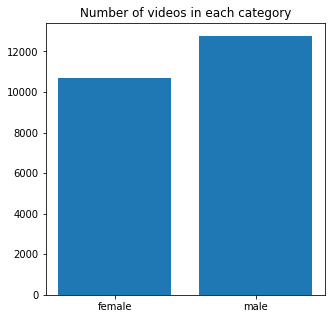

In [ ]:
#see how many males and females we have
gender = ['female', 'male']
count = [len(np.where(np.array(labels) == 0)[0]), len(np.where(np.array(labels) == 1)[0])]

plt.figure(figsize = (5, 5))
plt.bar(gender, count)
plt.title('Number of videos in each category')
plt.show()

Now we can see that we have a more balanced dataset that we can use for video classification. 


# **Visualizing the video**



Now let's pick a random video print the path, class and play the video.

In [ ]:
#pic a random video and play it

rand_idx = np.random.choice(np.arange(0, len(video_files)))
file_path = video_files[rand_idx]
file_label = labels[rand_idx]
print(file_path)
print('\nMale\n' if file_label == 1 else '\nFemale\n')

mp4 = open(file_path, 'rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

/content/mp4/id02057/PXCPlxo7_MM/00221.mp4

Male



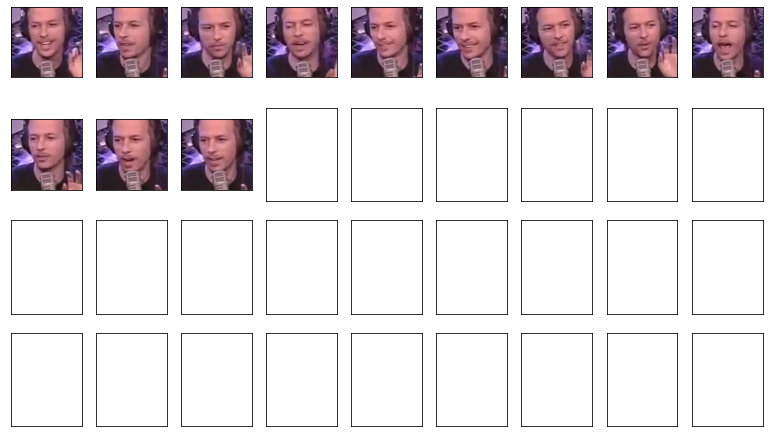

In [ ]:
#select the random video above and plot the frames of the video
count = 0
cap = cv2.VideoCapture(video_files[rand_idx])

ncols = 10
nrows = 5

# create the plots
fig = plt.figure(figsize = (15, 10))
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c) for r in range(1, nrows) for c in range(1, ncols) ]

# remove the x and y ticks
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#index for the axis
a = 0

x = 0
while(cap.isOpened()):
    #frameId = cap.get(1) #current frame number
    ret, frame = cap.read()

    if x % 10 == 0 and (frame is not None):

      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      axes[a].imshow(frame.astype('uint8'))
      a += 1     
    
    if (ret != True):
        break
    x += 1
cap.release()


In [ ]:
#confirming the frames per second in a video
cap= cv2.VideoCapture(video_files[10011])
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"A video has {fps} frames per second")

A video has 25 frames per second


#**Create a data Generator**



I will only be using the first 3 seconds of the video to be consistent when I am doing audio classification. Since we have a frame rate of 25 per second, I will be taking 15 (every 5th frame) frames from the first 75 frames. 

Then each frame will be loaded to a 4D numpy array where (axis 0 = height, axis 1 = width, axis 2 = frames, axis 3 = RGB channels)

In [ ]:
#Let's only take 3 seconds of the video. Since the videos are 25 fps the first three seconds has a total of 75 frames. We will get the frames that are divisible by 5 so we will
#get 15 total frames from each video

def vid_to_array(path):
  
  r = np.zeros([224, 224, 15])
  g = np.zeros([224, 224, 15])
  b = np.zeros([224, 224, 15])

  #start count
  count = 0
  idx = 0

  #video capture
  cap = cv2.VideoCapture(path)

  while(cap.isOpened()):
      #frameId = cap.get(1) #current frame number
      ret, frame = cap.read()

      if (count + 1) % 5 == 0:
        r[:, :, idx] = frame[:, :, 0]/255
        g[:, :, idx] = frame[:, :, 1]/255
        b[:, :, idx] = frame[:, :, 2]/255

      if count == 74:
        break
      count += 1
  cap.release()

  return np.stack([r, g, b], axis = 3)

In [ ]:
#create a data generator
def video_generator(paths, labels, batch_size = 16):

  while True:

    #get the number of batches
    number_of_batches = len(paths) // batch_size

    #set up video batches and label batches
    batches = [paths[i : i + batch_size] for i in range(0, len(paths), batch_size)]
    label_batches = [labels[i : i + batch_size] for i in range(0, len(paths), batch_size)]

    for b in range(number_of_batches):
      
      #create arrays to store batch
      x_batch = np.zeros([batch_size, 224, 224, 15, 3])
      y_batch = np.zeros([batch_size, 1])

      #get video batch and label batch
      batch = batches[b]
      label_batch = label_batches[b]

      #iterate through the batch path and get the array 
      for i, p in enumerate(batch):
        
        vid_array = vid_to_array(p)
        #store the result
        x_batch[i, :] = vid_array
        y_batch[i, :] = label_batch[i]
    
      yield {'video': x_batch}, {'class': y_batch}
      

# **Train/validation split**



Here I have manually seperated the train and validation set because I ran into memory issues in colab.

In [ ]:
#split to train and validation set
train_idx = int(np.floor(len(labels) * 0.9))

#split the train and test data accordingly
train_paths = video_files[:train_idx]
train_labels = labels[:train_idx]

#split the test data
val_paths = video_files[train_idx:]
val_labels = labels[train_idx:]

In [ ]:
#validation set
validation_set = np.zeros([150, 224, 224, 15, 3])
validation_labels = np.zeros([150, 1])

#select 100 random indexes from the validation set
#rand_val_idx = np.random.choice(np.arange(len(val_paths)), 150)
rand_val_idx = np.arange(len(val_paths[:150]))

for i, idx in enumerate(rand_val_idx):

  #vid path
  path = val_paths[idx]
  label = val_labels[idx]

  validation_set[i, :] = vid_to_array(path)
  validation_labels[i, :] = label


# **Create a 3D Convolutional Neural Network Model**



Below I have created the 3D CNN model.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Average, Activation, BatchNormalization, Flatten, Conv3D, AveragePooling3D, MaxPooling3D, GlobalMaxPooling3D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.utils.vis_utils import plot_model

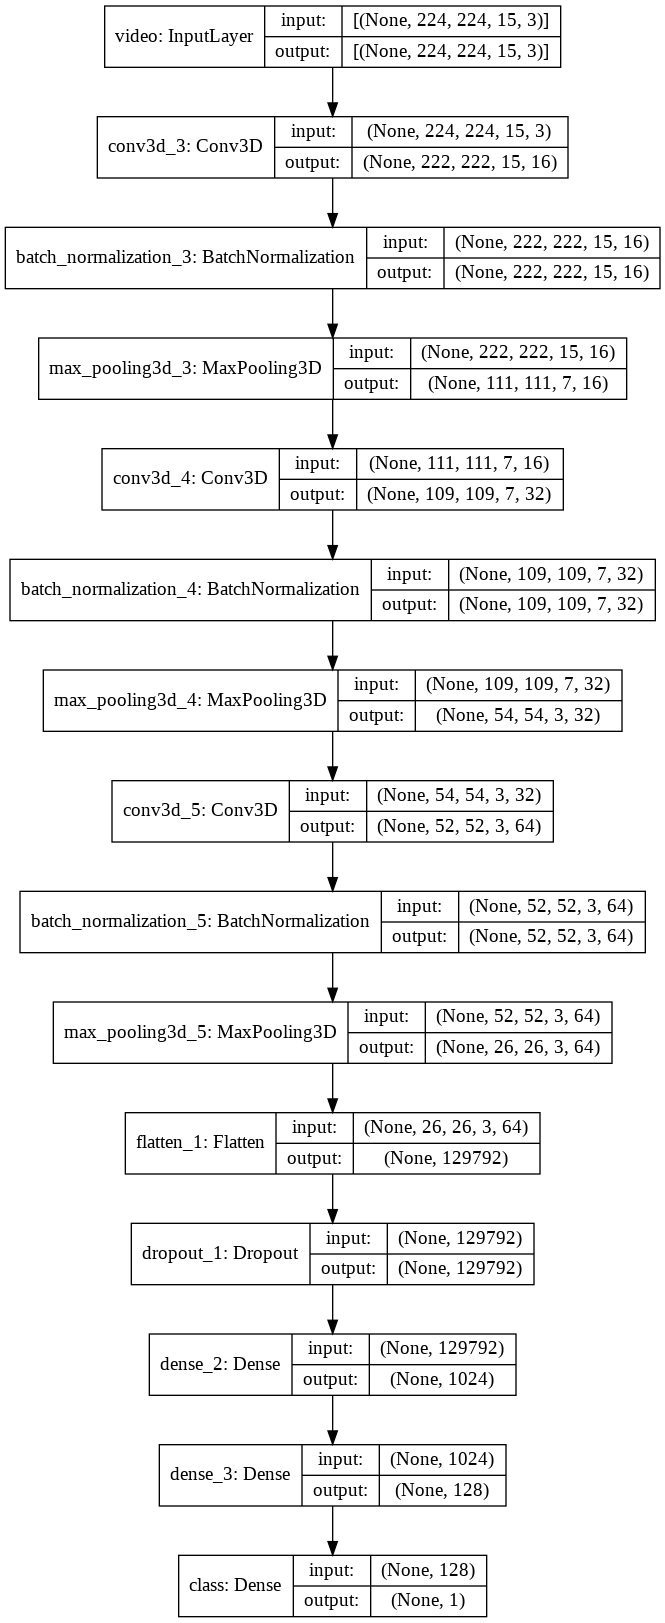

In [ ]:
#3d CNN
def cnn_model(x):
    
    inputs = x
    x = tf.keras.layers.Conv3D(16, kernel_size = (3, 3, 1),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
    
    x = tf.keras.layers.Conv3D(32, kernel_size = (3, 3, 1), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 2))(x)
    
    x = tf.keras.layers.Conv3D(64, kernel_size = (3, 3, 1), activation = 'relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 1))(x)
    
    # x = tf.keras.layers.Conv3D(64, kernel_size = (3, 3, 1), activation = 'relu')(x) 
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.MaxPool3D(pool_size = (2, 2, 1))(x)
   
    return x

#input
input_samp = np.zeros([16, 224, 224, 15, 3])

#input
input = Input(input_samp[0, :].shape, name = 'video')
out = cnn_model(input)
out = Flatten()(out)
out = Dropout(0.5)(out)
out = Dense(1024, activation = 'relu')(out)
out = Dense(128, activation = 'relu')(out)
output = Dense(1, activation = 'sigmoid', name = 'class')(out)

#create the model
video_cnn_model = Model(input, output)

#plot the model
plot_model(video_cnn_model, show_shapes = True, show_layer_names = True, to_file = 'test_model.png')

In [ ]:
#compile the model
opt = tf.optimizers.Adam(0.001)

#learning rate scheduler
def lr_schedule(epoch, lr):
    
    if (epoch + 1) % 5 == 0:
        
        lr *= 0.2
    
    return max(lr, 3e-7)

opt = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.0, nesterov=False, name='SGD')


#compile model
video_cnn_model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = 'accuracy')

#callbacks
#create a callback to stop the model when loss get higher
cb = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5, mode = 'auto')

cb_lr = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

#fit model
history = video_cnn_model.fit(video_generator(train_paths, train_labels, batch_size = 16), validation_data = (validation_set, validation_labels),\
                    epochs = 10, steps_per_epoch = 200, callbacks = [cb])

Epoch 1/10
200/200 [==============================] - 342s 2s/step - loss: 0.6892 - accuracy: 0.7631 - val_loss: 0.5615 - val_accuracy: 0.7467
Epoch 2/10
200/200 [==============================] - 304s 2s/step - loss: 0.3268 - accuracy: 0.8634 - val_loss: 0.4022 - val_accuracy: 0.8467
Epoch 3/10
200/200 [==============================] - 305s 2s/step - loss: 0.2666 - accuracy: 0.8847 - val_loss: 0.2247 - val_accuracy: 0.9267
Epoch 4/10
200/200 [==============================] - 304s 2s/step - loss: 0.2228 - accuracy: 0.9059 - val_loss: 0.2863 - val_accuracy: 0.9000
Epoch 5/10
200/200 [==============================] - 304s 2s/step - loss: 0.1972 - accuracy: 0.9206 - val_loss: 0.1972 - val_accuracy: 0.9467
Epoch 6/10
200/200 [==============================] - 300s 2s/step - loss: 0.1817 - accuracy: 0.9300 - val_loss: 0.1713 - val_accuracy: 0.9533
Epoch 7/10
200/200 [==============================] - 304s 2s/step - loss: 0.1462 - accuracy: 0.9484 - val_loss: 0.1229 - val_accuracy: 0.9400

# **Results summary**

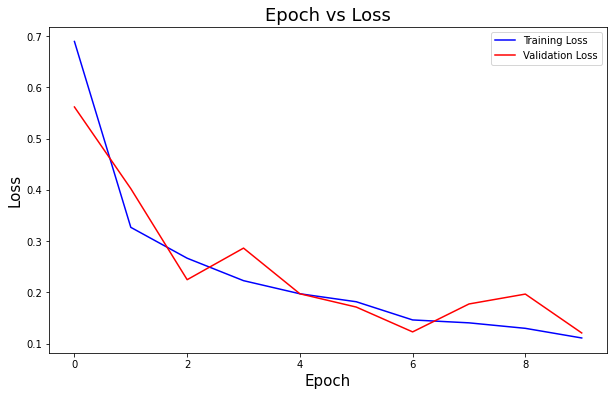

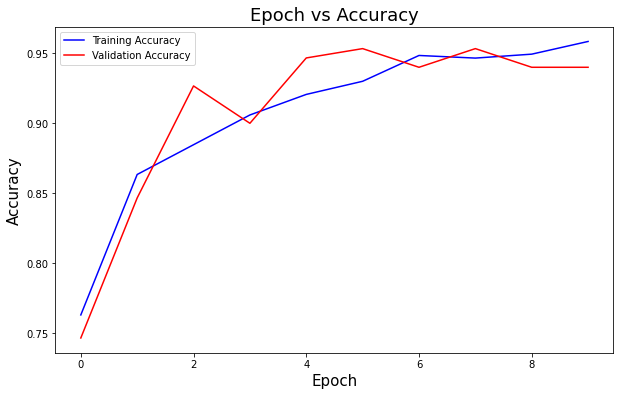

In [ ]:
#accuracy vs loss 
plt.figure(figsize = (10, 6))
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'], label = 'Training Loss', color = 'b')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_loss'], label = 'Validation Loss', color = 'r')
plt.legend()
plt.title('Epoch vs Loss', fontsize = 18)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Loss', fontsize = 15)
plt.show()

plt.figure(figsize = (10, 6))
plt.plot(np.arange(len(history.history['loss'])), history.history['accuracy'], label = 'Training Accuracy', color = 'b')
plt.plot(np.arange(len(history.history['val_loss'])), history.history['val_accuracy'], label = 'Validation Accuracy', color = 'r')
plt.legend()
plt.title('Epoch vs Accuracy', fontsize = 18)
plt.xlabel('Epoch', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

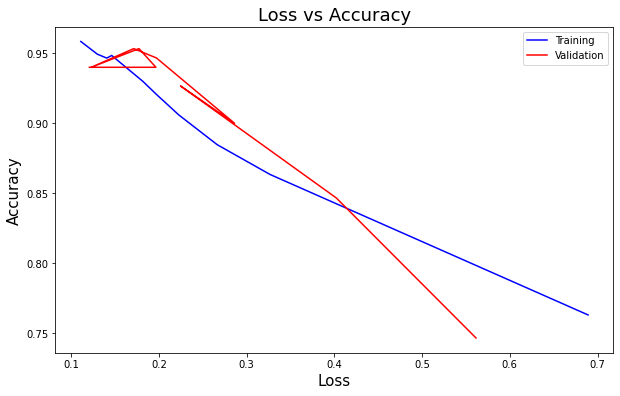

In [ ]:
#accuracy vs loss 
plt.figure(figsize = (10, 6))
plt.plot(history.history['loss'], history.history['accuracy'], label = 'Training', color = 'b')
plt.plot(history.history['val_loss'], history.history['val_accuracy'], label = 'Validation', color = 'r')
plt.legend()
plt.title('Loss vs Accuracy', fontsize = 18)
plt.xlabel('Loss', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.show()

# **Save and download the trained weights/model**

In [ ]:
video_cnn_model.save_weights('/content/vision.h5')

In [ ]:
from google.colab import files
files.download('vision.h5') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>